In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_244714/2647508162.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import sys
sys.path.append('/global/u1/a/ab2368/varying_dndzs/Varying_dndzs/')
from cardiac import templates
from cardiac import fields
from cardiac import spectrum
from matplotlib.lines import Line2D

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
# Hack to get Latex working on Perlmutter. Due to Joe de Rose
os.environ['PATH'] = '/global/common/sw/cray/sles15/x86_64/texlive/live/gcc/8.2.0/tiozj27/bin/x86_64-linux/:{}'.format(os.environ['PATH'])

plt.style.use('/global/u1/a/ab2368/plt_styles/JCAP_paper.mplstyle')
plots_dir = '/global/u1/a/ab2368/varying_dndzs/Varying_dndzs/paper/63ffea69c50c290da6f23d0e/plots/'

In [4]:
nside = 128
alpha = -2
lmax_pert = 100

n_samples_of_chi = 2**8 # (a power of 2). Number of samples in chi

In [47]:
sigma_sources = np.array([0.06, 0.2])
sigma_lenses = np.array([0.06])
sigma_of_shift_sources = np.array([0.011, 0.02])
sigma_of_shift_lenses = np.array([0.003, 0.006])
z_mean_sources = np.array([0.59, 0.8])
z_mean_lenses = np.array([0.59])

bvec = [0.786, 0.583, -0.406, -0.512, 1755]


In [41]:
title = 'ggl'

i=0
for sigma_source in sigma_sources:
    for sigma_lens in sigma_lenses:
        for sigma_of_shift_source in sigma_of_shift_sources:
            for sigma_of_shift_lens in sigma_of_shift_lenses:
                for z_mean_source in z_mean_sources:
                    for z_mean_lens in z_mean_lenses:
                        z_max_int = z_mean_source + 10*sigma_source # Higher end of the integration range in redshift
                        my_grid = fields.grid(nside, n_samples_of_chi, z_max_int=z_max_int)
                        temp_lens = templates.MockTemplate(sigma_of_shift_lens, nside, alpha, lmax_pert)
                        temp_source = templates.MockTemplate(sigma_of_shift_source, nside, alpha, lmax_pert)
                        temp_source.map = temp_lens.map * sigma_of_shift_source/sigma_of_shift_lens
                        gal_delta = fields.GalDelta(my_grid, sigma_lens, z_mean_lens, bvec, template_zmean_shifts=temp_lens)
                        gal_kappa = fields.GalShear(my_grid, sigma_source, z_mean_source, template_zmean_shifts=temp_source)
                        filename = '/pscratch/sd/a/ab2368/data/{}_alpha{}_lmaxpert{}_sigmazshiftlens{}_sigmazshiftsource{}_nside{}_sigmalens{}_sigmasource{}_zmeanlens{}_zmeansource{}'.format(title, alpha, lmax_pert, sigma_of_shift_lens, sigma_of_shift_source, nside, sigma_lens, sigma_source, z_mean_lens, z_mean_source)
                        ggl = spectrum.Spec(gal_delta, gal_kappa, get_cls=True, save=True, filename=filename)
                        i+=1
                        print('Done with {}/{}'.format(i, len(sigma_sources)*len(sigma_lenses)*len(sigma_of_shift_sources)*len(sigma_of_shift_lenses)*len(z_mean_sources)*len(z_mean_lenses)))

KeyboardInterrupt: 

In [122]:
def plot_bias(exp, ls=None, color=None, label=None, lw=None):
    plt.semilogy(exp.ells, exp.conv_bias/exp.unbiased_cls, ls='-', color=color, label=label, lw=lw)
    plt.semilogy(exp.ells, -exp.conv_bias/exp.unbiased_cls, ls='--', color=color, label=label, lw=lw)
    plt.xlabel(r'$l$')
    plt.ylabel(r'$\Delta C_l/C_l$')
    return

def subplot_bias(exp, fig, ls=None, color=None, label=None, lw=None):
    plt.figure(fig.number)
    plt.plot(exp.ells, exp.conv_bias/exp.unbiased_cls, ls=ls, color=color, label=label, lw=lw)
    plt.plot(exp.ells, -exp.conv_bias/exp.unbiased_cls, ls=ls, color=color, label=label, lw=lw)
    return

In [115]:
plt.style.use('/global/u1/a/ab2368/plt_styles/JCAP_paper_twothirdssize.mplstyle')


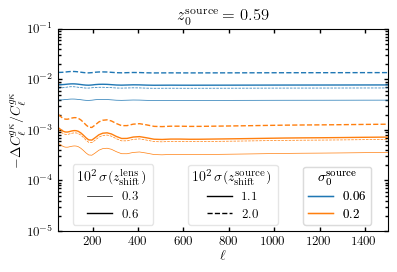

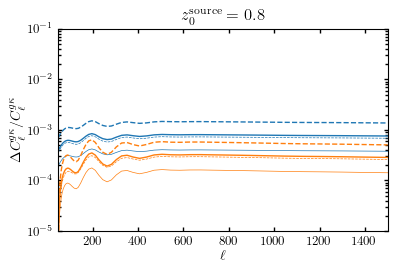

In [127]:
fig1 = plt.figure()
fig2 = plt.figure()
figs = [fig1, fig2]

title = 'ggl'
linestyles = np.array(['-', '--'])
linewidths = np.array([0.5, 1])

for i, z_mean_source in enumerate(z_mean_sources):
    for z_mean_lens in z_mean_lenses:
        for j, sigma_source in enumerate(sigma_sources):
            for sigma_lens in sigma_lenses:
                for sigma_of_shift_source, linestyle in zip(sigma_of_shift_sources, linestyles):
                    for sigma_of_shift_lens, linewidth in zip(sigma_of_shift_lenses, linewidths):
                        filename = '/pscratch/sd/a/ab2368/data/{}_alpha{}_lmaxpert{}_sigmazshiftlens{}_sigmazshiftsource{}_nside{}_sigmalens{}_sigmasource{}_zmeanlens{}_zmeansource{}'.format(title, alpha, lmax_pert, sigma_of_shift_lens, sigma_of_shift_source, nside, sigma_lens, sigma_source, z_mean_lens, z_mean_source)
                        ggl = spectrum.Spec(get_cls=False, load=True, filename=filename)
                        subplot_bias(ggl, figs[i], color="C{}".format(j), ls=linestyle, lw=linewidth)

plt.figure(figs[0].number)
plt.ylabel(r'$- \Delta C^{g\kappa}_\ell/ C^{g\kappa}_\ell$')
plt.title(r'$z_0^{\mathrm{source}}='+str(z_mean_sources[0])+'$')

leg_fontsize = 9
lines = [Line2D([0], [0], color='k', linewidth=lw, linestyle='-') for lw in linewidths]
labels = [r'$0.3$', r'$0.6$']
legend1 = plt.legend(lines, labels, loc='lower left', title=r'$10^2\,\sigma(z_{\mathrm{shift}}^{\mathrm{lens}})$', frameon=True, bbox_to_anchor=(0.025, 0., 0.5, 0.5), fontsize=leg_fontsize)

lines = [Line2D([0], [0], color='k', linewidth=1, linestyle=ls) for ls in linestyles]
labels = [r'$1.1$', r'$2.0$']
legend2 = plt.legend(lines, labels, loc='lower left', title=r'$10^2\,\sigma(z_{\mathrm{shift}}^{\mathrm{source}})$', frameon=True, bbox_to_anchor=(0.375, 0., 0.5, 0.5), fontsize=leg_fontsize)

colors = ["C{}".format(0), "C{}".format(1)]
lines = [Line2D([0], [0], color=c, linewidth=1, linestyle='-') for c in colors]
labels = sigma_sources.astype(str)
legend3 = plt.legend(lines, labels, loc='lower left', title=r'$\sigma_0^{\mathrm{source}}$', frameon=True, bbox_to_anchor=(0.725, 0., 0.5, 0.5), fontsize=leg_fontsize)

axes = plt.gca()
axes.add_artist(legend1)
axes.add_artist(legend2)
axes.add_artist(legend3)

plt.figure(figs[1].number)
plt.ylabel(r'$\Delta C^{g\kappa}_\ell/ C^{g\kappa}_\ell$ ')
plt.title(r'$z_0^{\mathrm{source}}='+str(z_mean_sources[1])+'$')


for fig, savetitle in zip(figs, ['sourcescloseby', 'sourcesfaraway']):
    plt.figure(fig.number)
    plt.yscale('log')
    plt.xlim([50, 1500])
    plt.ylim([1e-5, 1e-1])
    plt.xlabel(r'$\ell$')
    plt.savefig(plots_dir+'fig_mcbias_ggl_{}.pdf'.format(savetitle), bbox_inches='tight', dpi=600)

"\naxs[0].set_xticks(sigmas, (10*sigmas).astype(int).astype(str))\nplt.legend(bbox_to_anchor=(1, 0.7), frameon=True, reverse=True, title=r'$ 10^{2}\\,\\sigma(z_\\mathrm{shift})$')\n\naxs[0].set_ylabel(r'$\\int d\\ell \x08ig(\\Delta C^{\\kappa\\kappa}_\\ell/ C^{\\kappa\\kappa}_\\ell \x08ig)/ \\int d\\ell$')\nplt.savefig(plots_dir+'fig_mcbias_vs_sigma_shear.pdf', bbox_inches='tight', dpi=600)\n"

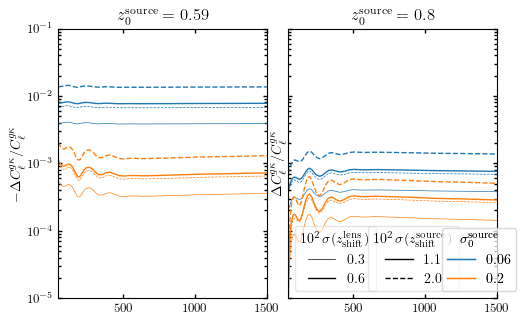

In [114]:
fig = plt.figure()
gs = fig.add_gridspec(nrows=1, ncols=2, hspace=0, wspace=0.1)
axs = gs.subplots(sharex=True, sharey=True)

title = 'ggl'
linestyles = np.array(['-', '--'])
linewidths = np.array([0.5, 1])

for i, z_mean_source in enumerate(z_mean_sources):
    for z_mean_lens in z_mean_lenses:
        for j, sigma_source in enumerate(sigma_sources):
            for sigma_lens in sigma_lenses:
                for sigma_of_shift_source, linestyle in zip(sigma_of_shift_sources, linestyles):
                    for sigma_of_shift_lens, linewidth in zip(sigma_of_shift_lenses, linewidths):
                        filename = '/pscratch/sd/a/ab2368/data/{}_alpha{}_lmaxpert{}_sigmazshiftlens{}_sigmazshiftsource{}_nside{}_sigmalens{}_sigmasource{}_zmeanlens{}_zmeansource{}'.format(title, alpha, lmax_pert, sigma_of_shift_lens, sigma_of_shift_source, nside, sigma_lens, sigma_source, z_mean_lens, z_mean_source)
                        ggl = spectrum.Spec(get_cls=False, load=True, filename=filename)
                        subplot_bias(ggl, axs[i], color="C{}".format(j), ls=linestyle, lw=linewidth)
                        
axs[0].set_ylabel(r'$- \Delta C^{g\kappa}_\ell/ C^{g\kappa}_\ell$')
axs[1].set_ylabel(r'$\Delta C^{g\kappa}_\ell/ C^{g\kappa}_\ell$ ')

axs[0].set_title(r'$z_0^{\mathrm{source}}='+str(z_mean_sources[0])+'$')
axs[1].set_title(r'$z_0^{\mathrm{source}}='+str(z_mean_sources[1])+'$')
              
plt.yscale('log')
plt.xlim([50, 1500])
plt.ylim([1e-5, 1e-1])


lines = [Line2D([0], [0], color='k', linewidth=lw, linestyle='-') for lw in linewidths]
labels = [r'$0.3$', r'$0.6$']
legend1 = plt.legend(lines, labels, loc='lower left', title=r'$10^2\,\sigma(z_{\mathrm{shift}}^{\mathrm{lens}})$', frameon=True, bbox_to_anchor=(0., 0., 0.5, 0.5))

lines = [Line2D([0], [0], color='k', linewidth=1, linestyle=ls) for ls in linestyles]
labels = [r'$1.1$', r'$2.0$']
legend2 = plt.legend(lines, labels, loc='lower left', title=r'$10^2\,\sigma(z_{\mathrm{shift}}^{\mathrm{source}})$', frameon=True, bbox_to_anchor=(0.35, 0., 0.5, 0.5))

colors = ["C{}".format(0), "C{}".format(1)]
lines = [Line2D([0], [0], color=c, linewidth=1, linestyle='-') for c in colors]
labels = sigma_sources.astype(str)
legend3 = plt.legend(lines, labels, loc='lower left', title=r'$\sigma_0^{\mathrm{source}}$', frameon=True, bbox_to_anchor=(0.7, 0., 0.5, 0.5))

axes = plt.gca()
axes.add_artist(legend1)
axes.add_artist(legend2)
axes.add_artist(legend3)

'''
axs[0].set_xticks(sigmas, (10*sigmas).astype(int).astype(str))
plt.legend(bbox_to_anchor=(1, 0.7), frameon=True, reverse=True, title=r'$ 10^{2}\,\sigma(z_\mathrm{shift})$')

axs[0].set_ylabel(r'$\int d\ell \big(\Delta C^{\kappa\kappa}_\ell/ C^{\kappa\kappa}_\ell \big)/ \int d\ell$')
plt.savefig(plots_dir+'fig_mcbias_vs_sigma_shear.pdf', bbox_inches='tight', dpi=600)
'''